In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

#

In [2]:
import utils.load_grid as lg

In [3]:
pgrid_dir = "data/output/dummy_grid/"
cases = lg.get_cases(pgrid_dir)

In [4]:
# Collect netcdf files
stts = lg.get_statuses(pgrid_dir)
# endn = lg.load_netcdfs_end(cases)

# Configuration variables
cvars = lg.load_configs(cases)
ncases = len(cases)

# Helpfiles
helps, hvars = lg.load_helpfiles(cases)

print("Done")

Configs:   0%|          | 0/30 [00:00<?, ?it/s]

Helpfiles: 100%|██████████| 30/30 [00:00<00:00, 37.04it/s]


Done


In [5]:
%matplotlib inline

In [6]:
count_solid = 0
count_steady = 0

for i in range(ncases):
    match stts[i]:
        case 11: count_steady += 1
        case 10: count_solid += 1

print("Total cases: %d"%ncases)
print("Steady state count : %d (%.3f %%)" % (count_steady , count_steady/ncases*100.0))
print("Solidified count   : %d (%.3f %%)" % (count_solid , count_solid/ncases*100.0))

Total cases: 30
Steady state count : 0 (0.000 %)
Solidified count   : 0 (0.000 %)


In [7]:
def plot_var_vs_time(y_key, y_lbl, default_col='black', logx=False, logy=True, scatter=False, ylims=None):

    y_key = str(y_key).strip()
    y_key_lower = y_key.lower()

    # options
    lw = 1.0
    al = 0.2
    col = default_col

    fig,ax = plt.subplots(1,1, figsize=(7,4))

    # for all cases
    max_time = 1.0
    show_legend = False
    for i in range(ncases):

        x_arr = np.array(helps[i]["Time"])
        max_time = max(max_time, np.amax(x_arr))

        # if not np.any(np.array(helps[i]["F_atm"]) < 1.0e-6):
        #     continue


        # handle key
        if y_key_lower in ["bar", "vmr"]:
            show_legend = True

            for v in lg.volatile_species:
                if y_key_lower == "bar":
                    key = v+"_atm_bar"
                elif y_key_lower == "vmr":
                    key = v+"_mr"
                if i == 0:
                    lbl = v
                else:
                    lbl = None
                y_arr = np.array(helps[i][key])
                col   = lg.volatile_colors[v]

                if np.all(y_arr < 1.0e-30):
                    continue
                if scatter:
                    ax.scatter(x_arr, y_arr, c=col, label=lbl, alpha=al, s=1)
                else:
                    ax.plot(x_arr, y_arr, c=col, label=lbl, alpha=al, lw=lw)

        else:
            y_arr = np.array(helps[i][y_key])
            if scatter:
                ax.scatter(x_arr, y_arr, c=col, alpha=al, s=1)
            else:
                ax.plot(x_arr, y_arr, c=col, alpha=al, lw=lw)


    # configure plot
    ax.set_xlabel("Time [yr]")
    ax.set_xlim(1.0e3, max_time)
    if logx:
        ax.set_xscale("log")

    ax.set_ylabel(y_lbl)
    if logy:
        ax.set_yscale("log")
    if y_key == "vmr":
        ax.set_ylim(1e-7, 1.1)

    if not (ylims == None):
        ax.set_ylim(ylims[0], ylims[1])

    # final things
    fig.tight_layout()
    if show_legend:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()



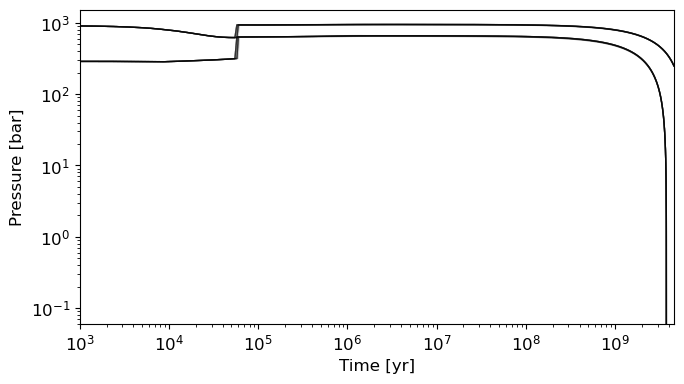

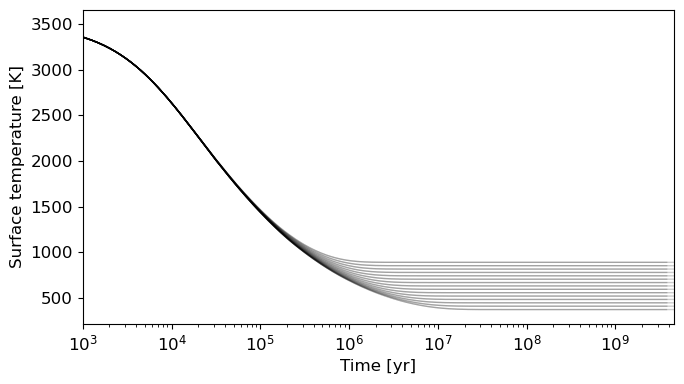

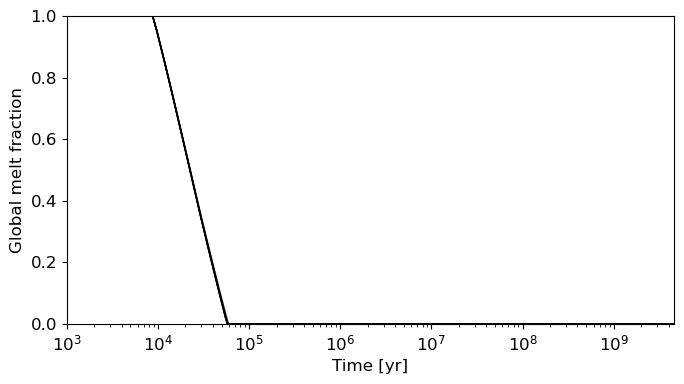

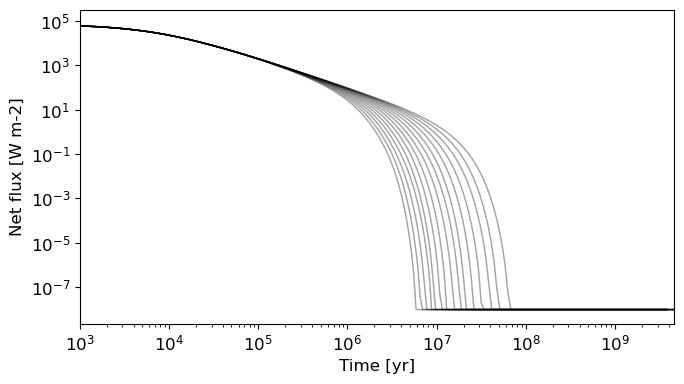

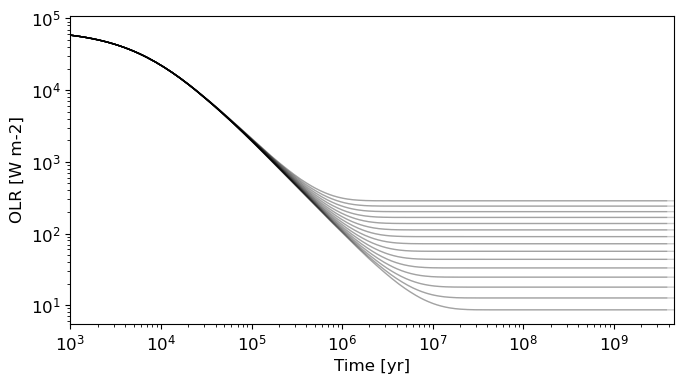

In [8]:
plt.close("all")
plot_var_vs_time("P_surf", "Pressure [bar]", logx=True)
plot_var_vs_time("T_surf", "Surface temperature [K]", logx=True, logy=False)
plot_var_vs_time("Phi_global", "Global melt fraction", logx=True, logy=False, ylims=(0,1))
plot_var_vs_time("F_atm", "Net flux [W m-2]", logx=True, logy=True)
plot_var_vs_time("F_olr", "OLR [W m-2]", logx=True, logy=True)

In [9]:
plt.close("all")

def plot_scale_height( default_col='black', logx=False, logy=True, scatter=False, ylims=None, nsamps=None, heatmap=True):

    # options
    lw = 1.0
    al = 0.2
    col = default_col

    fig,ax = plt.subplots(1,1, figsize=(7,4))

    grav = 9.82
    rgas = 8.314

    if nsamps == None:
        nsamps = ncases

    # for all cases
    max_time = 1.0
    show_legend = False

    x_2d = []
    y_2d = []
    for i in np.random.choice(range(ncases), size=nsamps):

        x_arr = np.array(helps[i]["Time"])
        max_time = max(max_time, np.amax(x_arr))

        # calculate mmw (kg/mol)
        mmw = np.zeros(len(x_arr))
        for v in lg.volatile_species:

            mmw_gas = 0.0
            match v:
                case "H2O": mmw_gas = 0.018015
                case "CO2": mmw_gas = 0.044009
                case "H2":  mmw_gas = 0.002016
                case "CO":  mmw_gas = 0.028010
                case "CH4": mmw_gas = 0.016040
                case "N2":  mmw_gas = 0.028014
                case _:     mmw_gas = 0.0
            mmw += (np.array(helps[i][v+"_mr"]) * mmw_gas)

        # temperatures
        tmp_arr = np.array(helps[i]["T_surf"])

        # calculate scale height
        y_arr = 1.0e-3 * rgas * tmp_arr / (mmw * grav)

        # store 2d
        x_2d.extend(x_arr)
        y_2d.extend(y_arr)

        # do plot
        if not heatmap:
            if scatter:
                ax.scatter(x_arr, y_arr, c=col, alpha=al, s=1)
            else:
                ax.plot(x_arr, y_arr, c=col, alpha=al, lw=lw)

    # heatmap
    if heatmap:
        # data
        x_2d = np.array(x_2d)
        y_2d = np.array(y_2d)

        x_2d = np.clip(x_2d, a_min=1.0, a_max=None)

        # histogram
        hmap, xedges, yedges = np.histogram2d(x_2d,y_2d,bins=30)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

        # plot
        ax.imshow(hmap.T, extent=extent, origin='lower')


    # configure plot
    ax.set_xlabel("Time [yr]")
    ax.set_xlim(1.0e3, max_time)
    if logx:
        ax.set_xscale("log")

    ax.set_ylabel("Scale height at surface [km]")
    if logy:
        ax.set_yscale("log")

    if not (ylims == None):
        ax.set_ylim(ylims[0], ylims[1])

    # final things
    fig.tight_layout()
    if show_legend:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()



AttributeError: module 'utils.load_grid' has no attribute 'volatile_species'

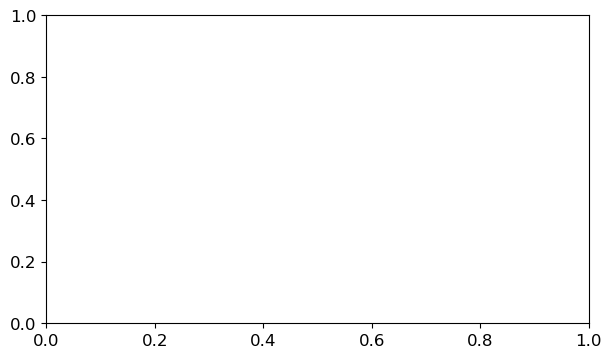

In [10]:
plot_scale_height(logx=True, logy=True, heatmap=False, nsamps=300)